# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from google.colab import files


#Upload required dataset files


In [3]:
# Upload files in Google Colab
uploaded = files.upload()

drivers = pd.read_csv("drivers.csv")
driver_standings = pd.read_csv("driver_standings.csv")
constructors = pd.read_csv("constructors.csv")
constructor_results = pd.read_csv("constructor_results.csv")
constructor_standings = pd.read_csv("constructor_standings.csv")
races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
qualifying = pd.read_csv("qualifying.csv")
circuits = pd.read_csv("circuits.csv")
pit_stops = pd.read_csv("pit_stops.csv")
lap_times = pd.read_csv("lap_times.csv")
status = pd.read_csv("status.csv")
seasons = pd.read_csv("seasons.csv")
sprint_results = pd.read_csv("sprint_results.csv")


Saving Verification File.docx to Verification File.docx
Saving circuits.csv to circuits.csv
Saving constructor_results.csv to constructor_results.csv
Saving constructor_standings.csv to constructor_standings.csv
Saving constructors.csv to constructors.csv
Saving driver_standings.csv to driver_standings.csv
Saving drivers.csv to drivers.csv
Saving lap_times.csv to lap_times.csv
Saving pit_stops.csv to pit_stops.csv
Saving qualifying.csv to qualifying.csv
Saving races.csv to races.csv
Saving results.csv to results.csv
Saving seasons.csv to seasons.csv
Saving sprint_results.csv to sprint_results.csv
Saving status.csv to status.csv


#Preprocess the uploaded datasets

In [4]:
# Function to clean and preprocess data
def preprocess_f1_data(
    races, circuits, results, drivers, constructors, driver_standings,
    constructor_standings, pit_stops, lap_times, qualifying, sprint_results
):
    races['date'] = pd.to_datetime(races['date'])
    pit_stops['time'] = pd.to_datetime(pit_stops['time'], errors='coerce')

    # Handling missing values
    driver_standings.fillna(0, inplace=True)
    constructor_standings.fillna(0, inplace=True)
    results.fillna(0, inplace=True)
    sprint_results.fillna(0, inplace=True)

    # Merging datasets
    # races with circuits
    races = races.merge(circuits, on='circuitId', how='left')

    # results with driver and constructor data
    results = results.merge(drivers, on='driverId', how='left')
    results = results.merge(constructors, on='constructorId', how='left')
    results = results.merge(races[['raceId', 'year']], on='raceId', how='left')

    # driver standings with driver information
    driver_standings = driver_standings.merge(drivers[['driverId', 'surname']], on='driverId', how='left')

    # constructor standings with constructor information
    constructor_standings = constructor_standings.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')

    return {
        'races': races,
        'results': results,
        'driver_standings': driver_standings,
        'constructor_standings': constructor_standings,
        'pit_stops': pit_stops,
        'lap_times': lap_times,
        'qualifying': qualifying,
        'sprint_results': sprint_results
    }

cleaned_data = preprocess_f1_data(
    races, circuits, results, drivers, constructors, driver_standings,
    constructor_standings, pit_stops, lap_times, qualifying, sprint_results
)

for name, df in cleaned_data.items():
    df.to_csv(f'cleaned_{name}.csv', index=False)

print("\n\nData preprocessing completed! Cleaned files saved.")

<ipython-input-4-b5046b0f33de>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pit_stops['time'] = pd.to_datetime(pit_stops['time'], errors='coerce')




Data preprocessing completed! Cleaned files saved.


#Feature Engineering

In [5]:
def feature_engineering():
    results_with_year = results.merge(races[['raceId', 'year']], on='raceId', how='left')
    constructor_standings_with_year = constructor_standings.merge(races[['raceId', 'year']], on='raceId', how='left')

    # ---- Driver Consistency Features ----
    driver_performance = results_with_year.groupby(['year', 'driverId']).agg(
        avg_finish_position=('positionOrder', 'mean'),
        std_finish_position=('positionOrder', 'std')
    ).reset_index()

    qualifying_performance = qualifying.groupby(['driverId']).agg(
        avg_qualifying_position=('position', 'mean')
    ).reset_index()

    driver_consistency = driver_performance.merge(qualifying_performance, on='driverId', how='left')

    # ---- Team Strength Features ----
    team_strength = constructor_standings_with_year.groupby(['year', 'constructorId']).agg(
        avg_points=('points', 'mean'),
        win_rate=('wins', lambda x: np.sum(x) / len(x))
    ).reset_index()

    # 🔹 DNF Rate per team
    dnf_status = status[status['status'].str.contains("Retired|Accident|Engine", na=False)]
    dnf_results = results_with_year[results_with_year['statusId'].isin(dnf_status['statusId'])]

    dnf_rate = dnf_results.groupby(['year', 'constructorId']).size().reset_index(name='dnf_count')
    dnf_rate = dnf_rate.merge(team_strength[['year', 'constructorId']], on=['year', 'constructorId'], how='right').fillna(0)
    dnf_rate['dnf_rate'] = dnf_rate['dnf_count'] / len(results_with_year)

    team_strength = team_strength.merge(dnf_rate[['year', 'constructorId', 'dnf_rate']], on=['year', 'constructorId'], how='left')

    # ---- Track Complexity Features ----
    lap_positions = lap_times.groupby(['raceId', 'driverId']).agg(
        position_changes=('position', lambda x: x.iloc[0] - x.iloc[-1])
    ).reset_index()

    track_overtakes = lap_positions.groupby('raceId')['position_changes'].sum().reset_index()
    track_overtakes = track_overtakes.merge(races[['raceId', 'circuitId']], on='raceId')
    track_overtakes = track_overtakes.groupby('circuitId')['position_changes'].mean().reset_index()
    track_overtakes.rename(columns={'position_changes': 'avg_overtakes'}, inplace=True)

    pit_stop_duration = pit_stops.groupby(['raceId', 'driverId']).agg(
        avg_pit_time=('milliseconds', 'mean')
    ).reset_index()

    track_pit_stops = pit_stop_duration.groupby('raceId')['avg_pit_time'].mean().reset_index()
    track_pit_stops = track_pit_stops.merge(races[['raceId', 'circuitId']], on='raceId')
    track_pit_stops = track_pit_stops.groupby('circuitId')['avg_pit_time'].mean().reset_index()

    track_complexity = track_overtakes.merge(track_pit_stops, on='circuitId', how='left')

    # Save processed data
    driver_consistency.to_csv("driver_consistency.csv", index=False)
    team_strength.to_csv("team_strength.csv", index=False)
    track_complexity.to_csv("track_complexity.csv", index=False)

    return {
        'driver_consistency': driver_consistency,
        'team_strength': team_strength,
        'track_complexity': track_complexity
    }

# 🔹 Run feature engineering
features = feature_engineering()
print("Feature engineering complete!")


Feature engineering complete!


##1.Driver & Constructor Performance
####	Identify dominant drivers and constructors by analyzing win ratios and podium finishes.
#### Assess the relationship between career longevity and success metrics (wins, podiums, points).


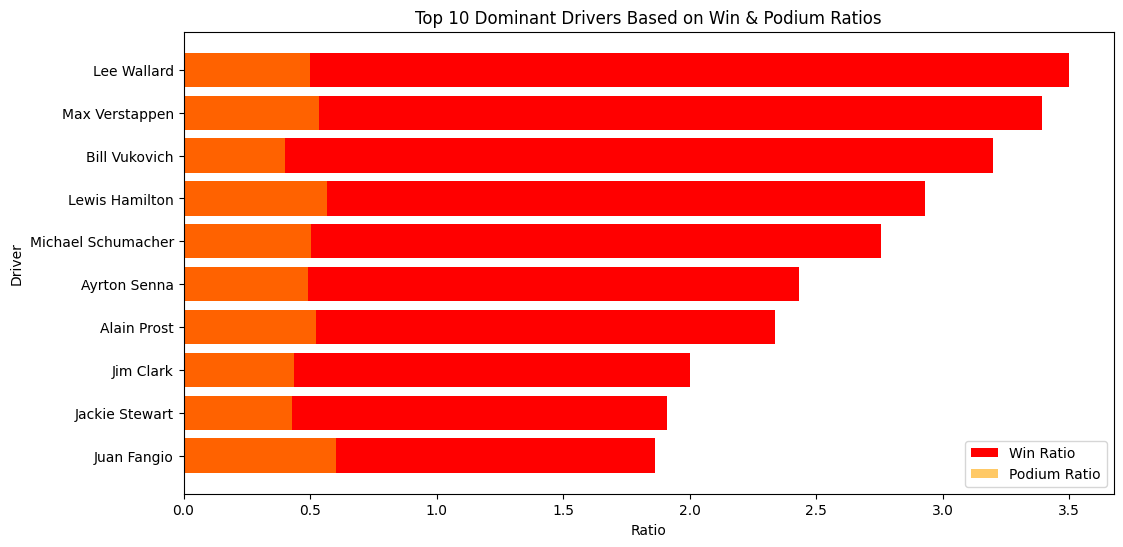

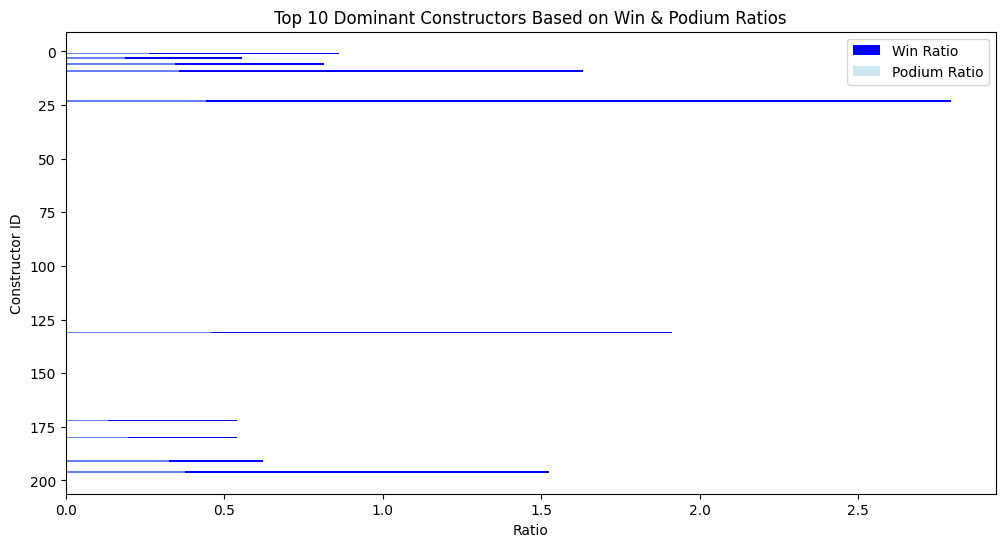

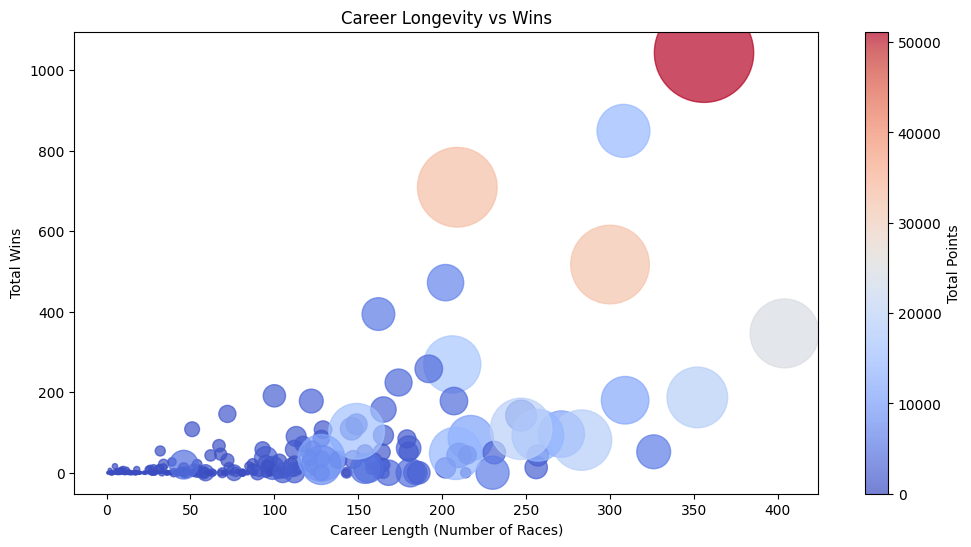

In [6]:
# Identify dominant drivers
# Calculate total races per driver
total_races = results.groupby("driverId")["raceId"].count().reset_index()
total_races.columns = ["driverId", "total_races"]

# Calculate wins and podium finishes per driver
wins = driver_standings.groupby("driverId")["wins"].sum().reset_index()
wins.columns = ["driverId", "total_wins"]

podiums = results[results["positionOrder"] <= 3].groupby("driverId")["positionOrder"].count().reset_index()
podiums.columns = ["driverId", "total_podiums"]

# Merge data
driver_performance = total_races.merge(wins, on="driverId", how="left").merge(podiums, on="driverId", how="left").fillna(0)
driver_performance = driver_performance.merge(drivers[["driverId", "forename", "surname"]], on="driverId")

driver_performance["win_ratio"] = driver_performance["total_wins"] / driver_performance["total_races"]
driver_performance["podium_ratio"] = driver_performance["total_podiums"] / driver_performance["total_races"]

dominant_drivers = driver_performance.sort_values("win_ratio", ascending=False).head(10)

# Visualization - Top Dominant Drivers
plt.figure(figsize=(12, 6))
plt.barh(dominant_drivers["forename"] + " " + dominant_drivers["surname"], dominant_drivers["win_ratio"], color="red", label="Win Ratio")
plt.barh(dominant_drivers["forename"] + " " + dominant_drivers["surname"], dominant_drivers["podium_ratio"], color="orange", alpha=0.6, label="Podium Ratio")
plt.xlabel("Ratio")
plt.ylabel("Driver")
plt.title("Top 10 Dominant Drivers Based on Win & Podium Ratios")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Identify dominant constructors
constructor_wins = constructor_standings.groupby("constructorId")["wins"].sum().reset_index()
constructor_wins.columns = ["constructorId", "total_wins"]

constructor_podiums = results[results["positionOrder"] <= 3].groupby("constructorId")["positionOrder"].count().reset_index()
constructor_podiums.columns = ["constructorId", "total_podiums"]

constructor_races = results.groupby("constructorId")["raceId"].count().reset_index()
constructor_races.columns = ["constructorId", "total_races"]

constructor_performance = constructor_races.merge(constructor_wins, on="constructorId", how="left").merge(constructor_podiums, on="constructorId", how="left").fillna(0)
constructor_performance["win_ratio"] = constructor_performance["total_wins"] / constructor_performance["total_races"]
constructor_performance["podium_ratio"] = constructor_performance["total_podiums"] / constructor_performance["total_races"]

dominant_constructors = constructor_performance.sort_values("win_ratio", ascending=False).head(10)

# Visualization - Top Dominant Constructors
plt.figure(figsize=(12, 6))
plt.barh(dominant_constructors["constructorId"], dominant_constructors["win_ratio"], color="blue", label="Win Ratio")
plt.barh(dominant_constructors["constructorId"], dominant_constructors["podium_ratio"], color="lightblue", alpha=0.6, label="Podium Ratio")
plt.xlabel("Ratio")
plt.ylabel("Constructor ID")
plt.title("Top 10 Dominant Constructors Based on Win & Podium Ratios")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Assessing Relationship Between Career Longevity and Success Metrics
driver_career = results.groupby("driverId")["raceId"].nunique().reset_index()
driver_career.columns = ["driverId", "career_length"]

driver_success = driver_career.merge(driver_standings.groupby("driverId")["wins"].sum().reset_index(), on="driverId")
driver_success = driver_success.merge(driver_standings.groupby("driverId")["points"].sum().reset_index(), on="driverId")

driver_success = driver_success.merge(drivers[["driverId", "forename", "surname"]], on="driverId")

# Scatter Plot - Career Longevity vs Wins
plt.figure(figsize=(12, 6))
plt.scatter(driver_success["career_length"], driver_success["wins"], c=driver_success["points"], cmap="coolwarm", s=driver_success["points"] / 10, alpha=0.7)
plt.xlabel("Career Length (Number of Races)")
plt.ylabel("Total Wins")
plt.title("Career Longevity vs Wins")
plt.colorbar(label="Total Points")
plt.show()

##2.	Qualifying vs. Race Performance
####	How does starting grid position impact final race results? Do certain drivers excel at making up positions?

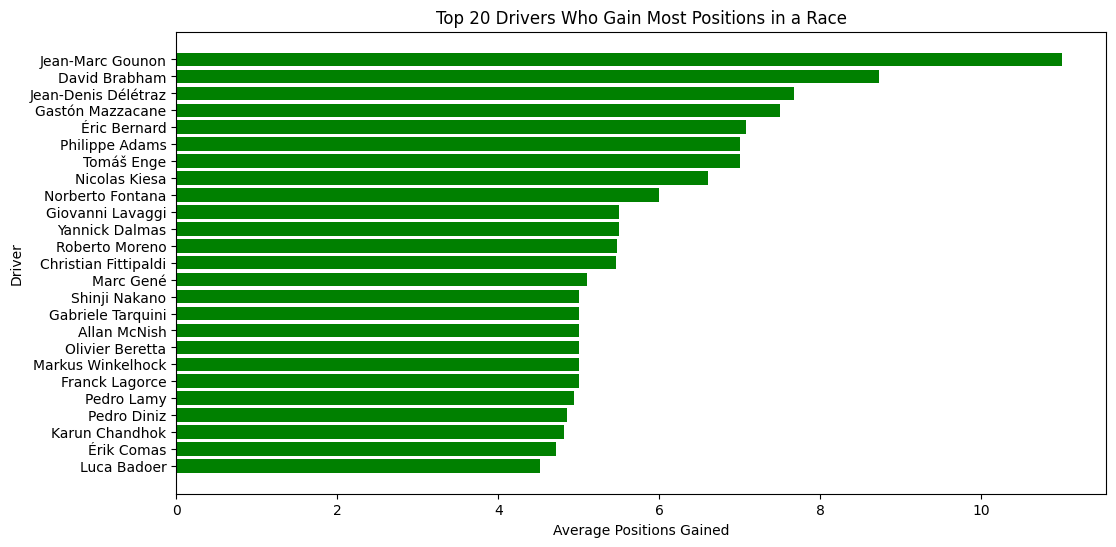

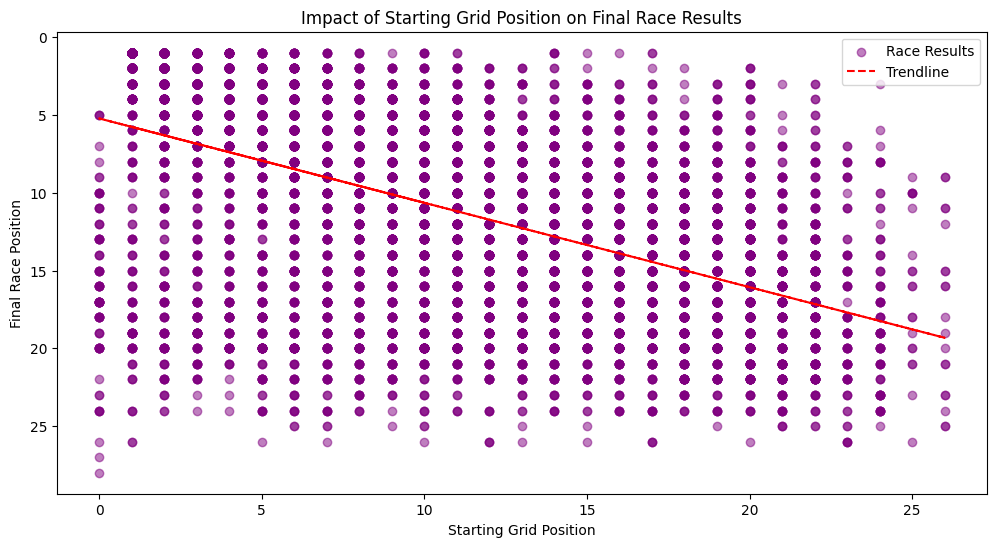

In [7]:

# Merge qualifying and race results
grid_vs_race = results.merge(qualifying, on=["raceId", "driverId"], how="inner")

# Calculate position changes
grid_vs_race["position_change"] = grid_vs_race["grid"] - grid_vs_race["positionOrder"]

# Average position change per driver
driver_position_change = grid_vs_race.groupby("driverId")["position_change"].mean().reset_index()
driver_position_change = driver_position_change.merge(drivers[["driverId", "forename", "surname"]], on="driverId")

driver_position_change = driver_position_change.sort_values("position_change", ascending=False).head(25)

# Visualization - Top Drivers Gaining Positions
plt.figure(figsize=(12, 6))
plt.barh(driver_position_change["forename"] + " " + driver_position_change["surname"], driver_position_change["position_change"], color="green")
plt.xlabel("Average Positions Gained")
plt.ylabel("Driver")
plt.title("Top 20 Drivers Who Gain Most Positions in a Race")
plt.gca().invert_yaxis()
plt.show()

# Scatter plot with trendline
plt.figure(figsize=(12, 6))
plt.scatter(grid_vs_race["grid"], grid_vs_race["positionOrder"], alpha=0.5, color="purple", label="Race Results")

# Best-fit line (trendline)
z = np.polyfit(grid_vs_race["grid"], grid_vs_race["positionOrder"], 1)
p = np.poly1d(z)
plt.plot(grid_vs_race["grid"], p(grid_vs_race["grid"]), color="red", linestyle="dashed", label="Trendline")

plt.xlabel("Starting Grid Position")
plt.ylabel("Final Race Position")
plt.title("Impact of Starting Grid Position on Final Race Results")
plt.gca().invert_yaxis()  # Invert Y-axis to align with ranking order (1st is at the top)
plt.legend()
plt.show()


##3.	Pit Stop Strategies
####Evaluate optimal pit stop frequency and timing for race success.
####Analyze pit stop efficiency and its influence on race outcomes.


Pit Stops Columns: Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'],
      dtype='object')


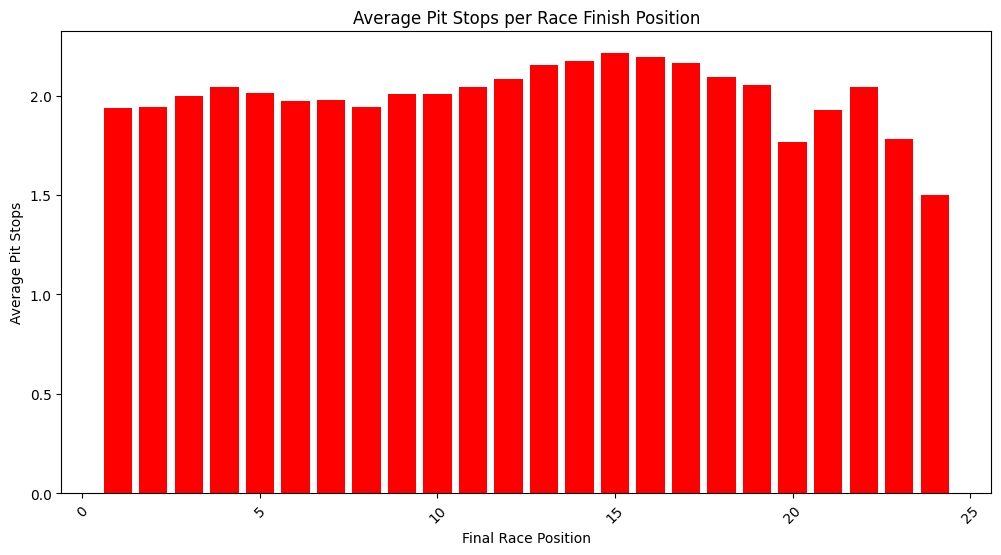

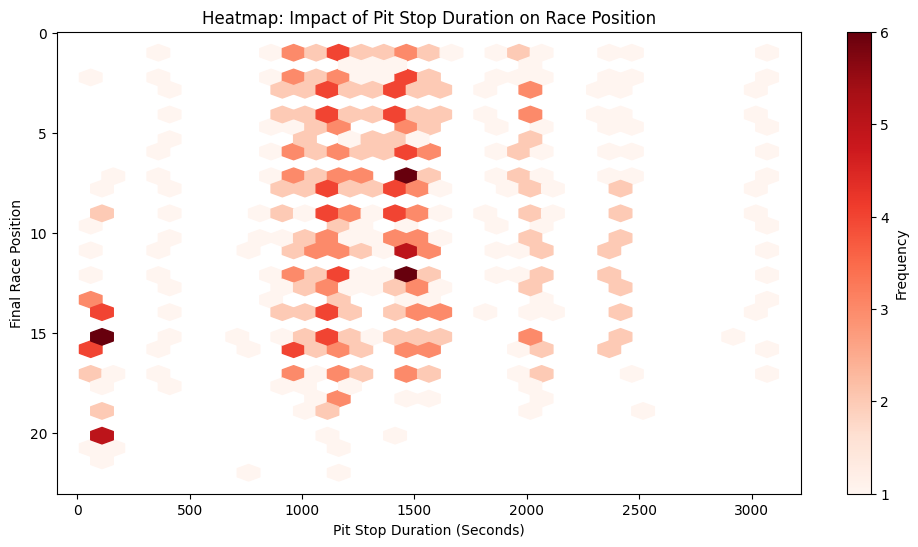

In [8]:
# Print available columns for debugging
print("Pit Stops Columns:", pit_stops.columns)

# Merge with race results
pit_stops_merged = pit_stops.merge(results, on=["raceId", "driverId"], how="inner")

# Number of pit stops per driver per race
pit_stop_counts = pit_stops_merged.groupby(["raceId", "driverId"]).size().reset_index(name="pit_stop_count")

# Merge with race finishing positions
pit_stop_counts = pit_stop_counts.merge(results[["raceId", "driverId", "positionOrder"]], on=["raceId", "driverId"])

# Average number of pit stops per finishing position
avg_pit_stops = pit_stop_counts.groupby("positionOrder")["pit_stop_count"].mean().reset_index()

# Visualization 1 - Average Pit Stops per Race Finish Position
plt.figure(figsize=(12, 6))
plt.bar(avg_pit_stops["positionOrder"], avg_pit_stops["pit_stop_count"], color="red")
plt.xlabel("Final Race Position")
plt.ylabel("Average Pit Stops")
plt.title("Average Pit Stops per Race Finish Position")
plt.xticks(rotation=45)
plt.show()

# Convert 'duration' from string format ("mm:ss.sss") to float (seconds)
def convert_duration_to_seconds(duration_str):
    try:
        if isinstance(duration_str, str):
            minutes, seconds = duration_str.split(":")
            return float(minutes) * 60 + float(seconds)
        return np.nan  # Return NaN if value is not a valid string
    except:
        return np.nan  # Handle unexpected cases

# Apply conversion
pit_stops_merged["pit_stop_duration"] = pit_stops_merged["duration"].apply(convert_duration_to_seconds)

# Drop NaN values (if conversion failed for some rows)
pit_stops_merged = pit_stops_merged.dropna(subset=["pit_stop_duration"])

# Plot Heatmap - Pit Stop Duration vs. Final Race Position
plt.figure(figsize=(12, 6))

plt.hexbin(
    pit_stops_merged["pit_stop_duration"],
    pit_stops_merged["positionOrder"],
    gridsize=30, cmap="Reds", mincnt=1
)

plt.colorbar(label="Frequency")
plt.xlabel("Pit Stop Duration (Seconds)")
plt.ylabel("Final Race Position")
plt.title("Heatmap: Impact of Pit Stop Duration on Race Position")
plt.gca().invert_yaxis()  # 1st place at the top
plt.show()

##4.	Head-to-Head Driver Analysis:
####Which rivalries have been the most competitive? Identify head-to-head stats based on race finishes.

<ipython-input-9-d2cb91a897e5>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


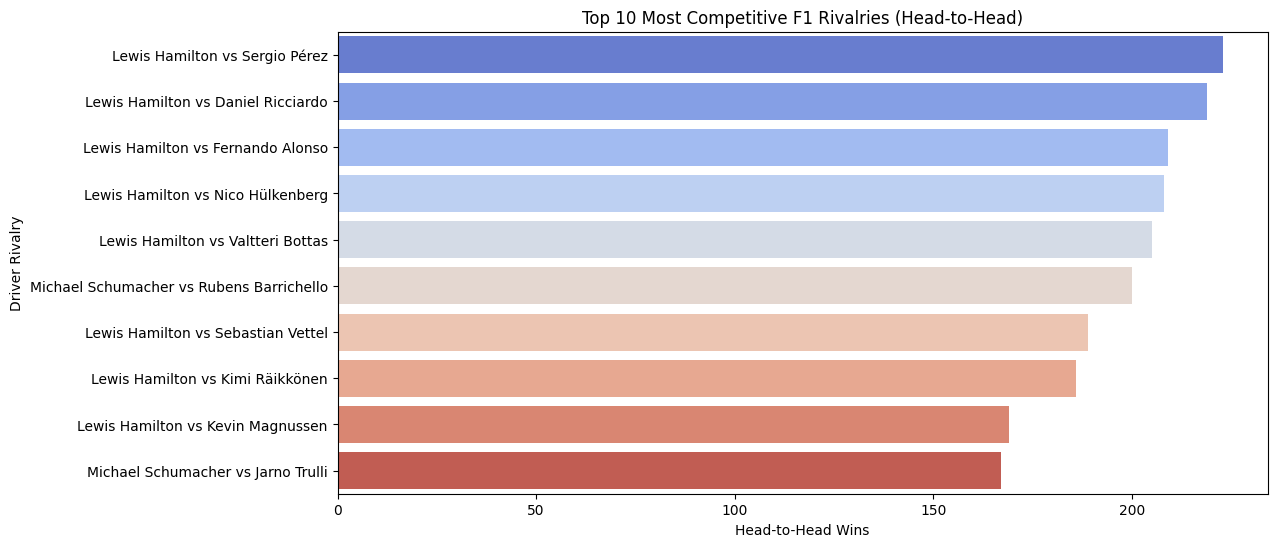

In [9]:
from itertools import combinations

# Merge results with drivers to get driver names, adding suffixes to avoid duplicates
results = results.merge(drivers[["driverId", "forename", "surname"]], on="driverId", suffixes=("", "_driver"))


# Create driver name column
results["driver_name"] = results["forename"] + " " + results["surname"]

# Function to calculate rivalries
def calculate_rivalries(results):
    head_to_head = {}

    for race_id, race_results in results.groupby("raceId"):
        driver_positions = race_results[["driver_name", "positionOrder"]].set_index("driver_name")["positionOrder"].to_dict()

        for driver1, driver2 in combinations(driver_positions.keys(), 2):
            winner, loser = (driver1, driver2) if driver_positions[driver1] < driver_positions[driver2] else (driver2, driver1)

            if (winner, loser) not in head_to_head:
                head_to_head[(winner, loser)] = 0
            head_to_head[(winner, loser)] += 1

    # Convert to DataFrame
    rivalries = pd.DataFrame([
        {"Driver1": d1, "Driver2": d2, "Competitiveness": count}
        for (d1, d2), count in head_to_head.items()
    ])

    return rivalries

# Compute rivalries
rivalries_df = calculate_rivalries(results)

# Select top 10 most competitive rivalries
top_rivalries = rivalries_df.sort_values("Competitiveness", ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_rivalries,
    x="Competitiveness",
    y=top_rivalries["Driver1"] + " vs " + top_rivalries["Driver2"],
    palette="coolwarm"
)
plt.xlabel("Head-to-Head Wins")
plt.ylabel("Driver Rivalry")
plt.title("Top 10 Most Competitive F1 Rivalries (Head-to-Head)")
plt.show()

##5.	Hypothetical Driver Swaps
####Swap two drivers between different teams and predict the impact on team and driver standings

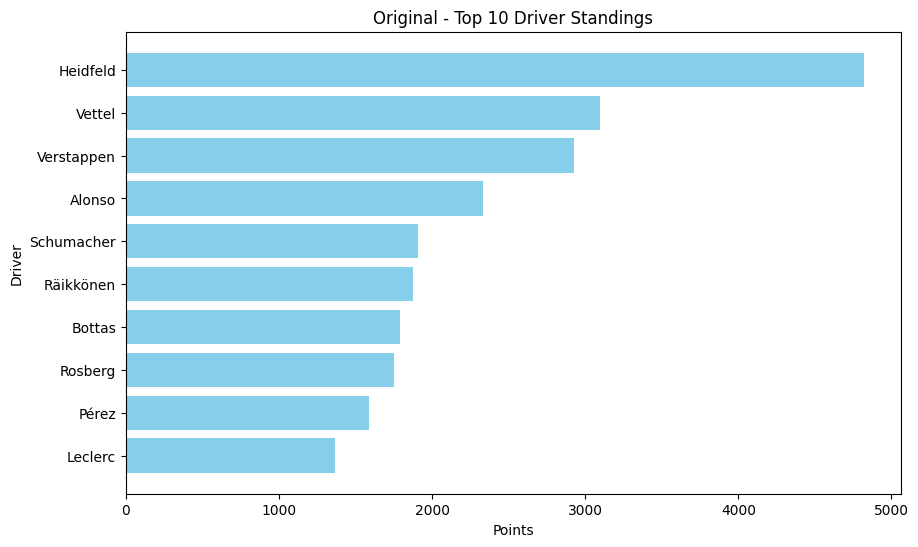

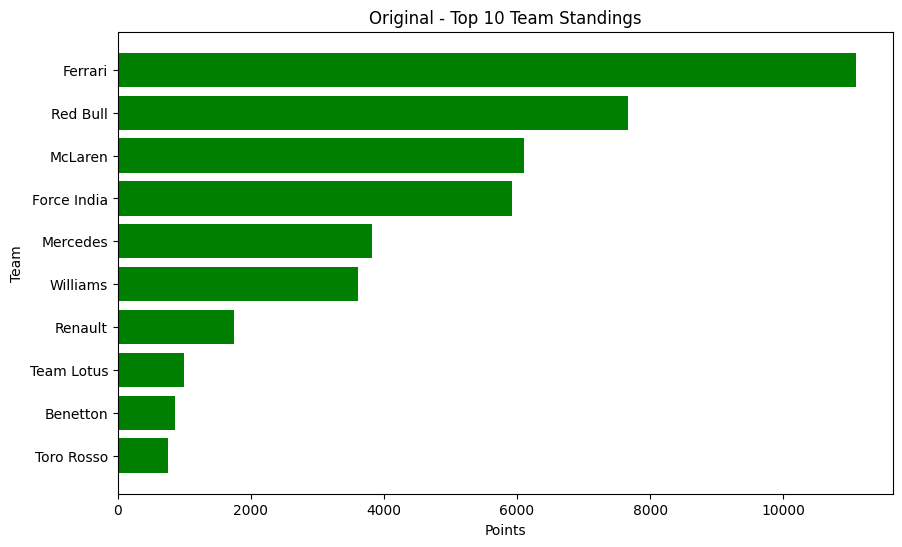

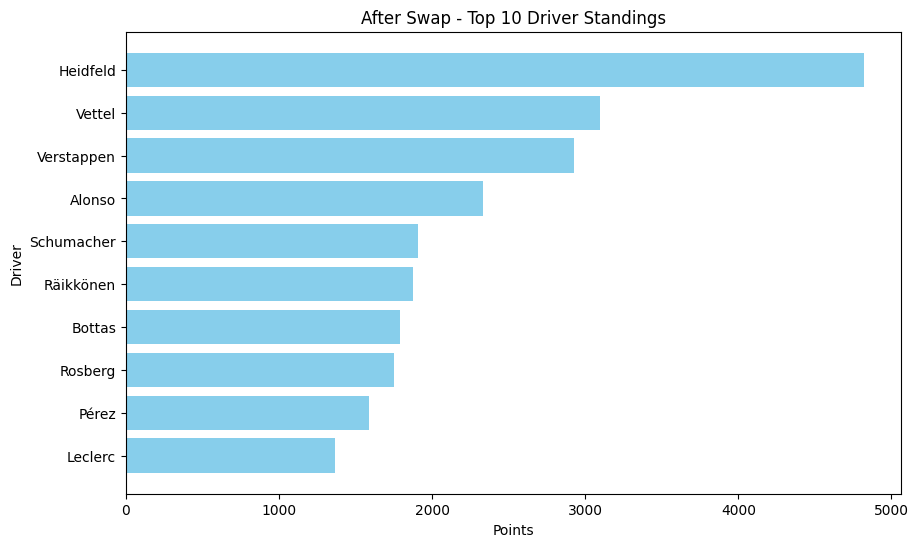

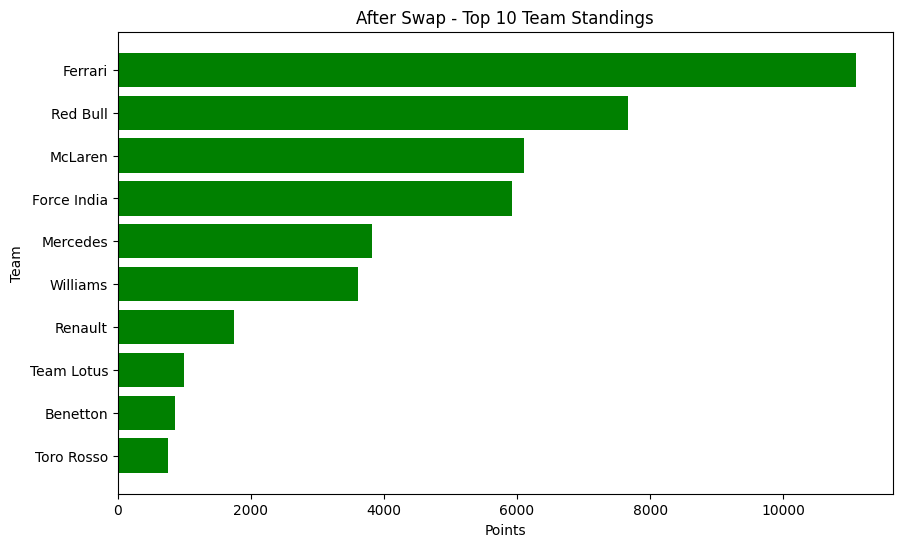

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to simulate a swap between two drivers and recalculate standings
def simulate_driver_swap(results, drivers, constructors, driver1_id, driver2_id):
    if driver1_id == driver2_id:
        raise ValueError("Driver IDs must be different for a swap.")

    swapped_results = results.copy()
    swapped_results['driverId'] = swapped_results['driverId'].replace({driver1_id: driver2_id, driver2_id: driver1_id})

    # Merge driver names (fixing duplicate column issue)
    merged_results = swapped_results.merge(
        drivers[['driverId', 'surname']], on='driverId', how='left', suffixes=('', '_driver')
    )

    # Merge constructor names (fixing duplicate column issue)
    merged_results = merged_results.merge(
        constructors[['constructorId', 'name']], on='constructorId', how='left', suffixes=('', '_team')
    )

    # Calculate driver points
    driver_points = merged_results.groupby('surname')['points'].sum().reset_index()
    driver_points = driver_points.sort_values(by='points', ascending=False)

    # Calculate team points
    team_points = merged_results.groupby('name')['points'].sum().reset_index()
    team_points = team_points.sort_values(by='points', ascending=False)

    return driver_points, team_points

# Visualization Function (Top 10 Drivers & Top 10 Teams)
def visualize_standings(driver_points, team_points, title):
    # Limit to Top 10 Drivers
    top_drivers = driver_points.head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(top_drivers['surname'], top_drivers['points'], color='skyblue')
    plt.xlabel('Points')
    plt.ylabel('Driver')
    plt.title(f'{title} - Top 10 Driver Standings')
    plt.gca().invert_yaxis()
    plt.show()

    # Limit to Top 10 Teams
    top_teams = team_points.head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(top_teams['name'], top_teams['points'], color='green')
    plt.xlabel('Points')
    plt.ylabel('Team')
    plt.title(f'{title} - Top 10 Team Standings')
    plt.gca().invert_yaxis()
    plt.show()


# Example swap between two different drivers (IDs 1 and 2)
original_driver_points, original_team_points = simulate_driver_swap(results, drivers, constructors, 1, 2)
swapped_driver_points, swapped_team_points = simulate_driver_swap(results, drivers, constructors, 2, 1)

# Visualizing results
visualize_standings(original_driver_points, original_team_points, 'Original')
visualize_standings(swapped_driver_points, swapped_team_points, 'After Swap')

##7.	Team Performance Comparison
####Compare team success rates against different opponents with and without considering circuit factor.

<ipython-input-16-6a30117b1452>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='avg_points_per_race', y='name', data=top_teams, palette='coolwarm')
<ipython-input-16-6a30117b1452>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='podium_finishes', y='name', data=top_teams, palette='coolwarm')


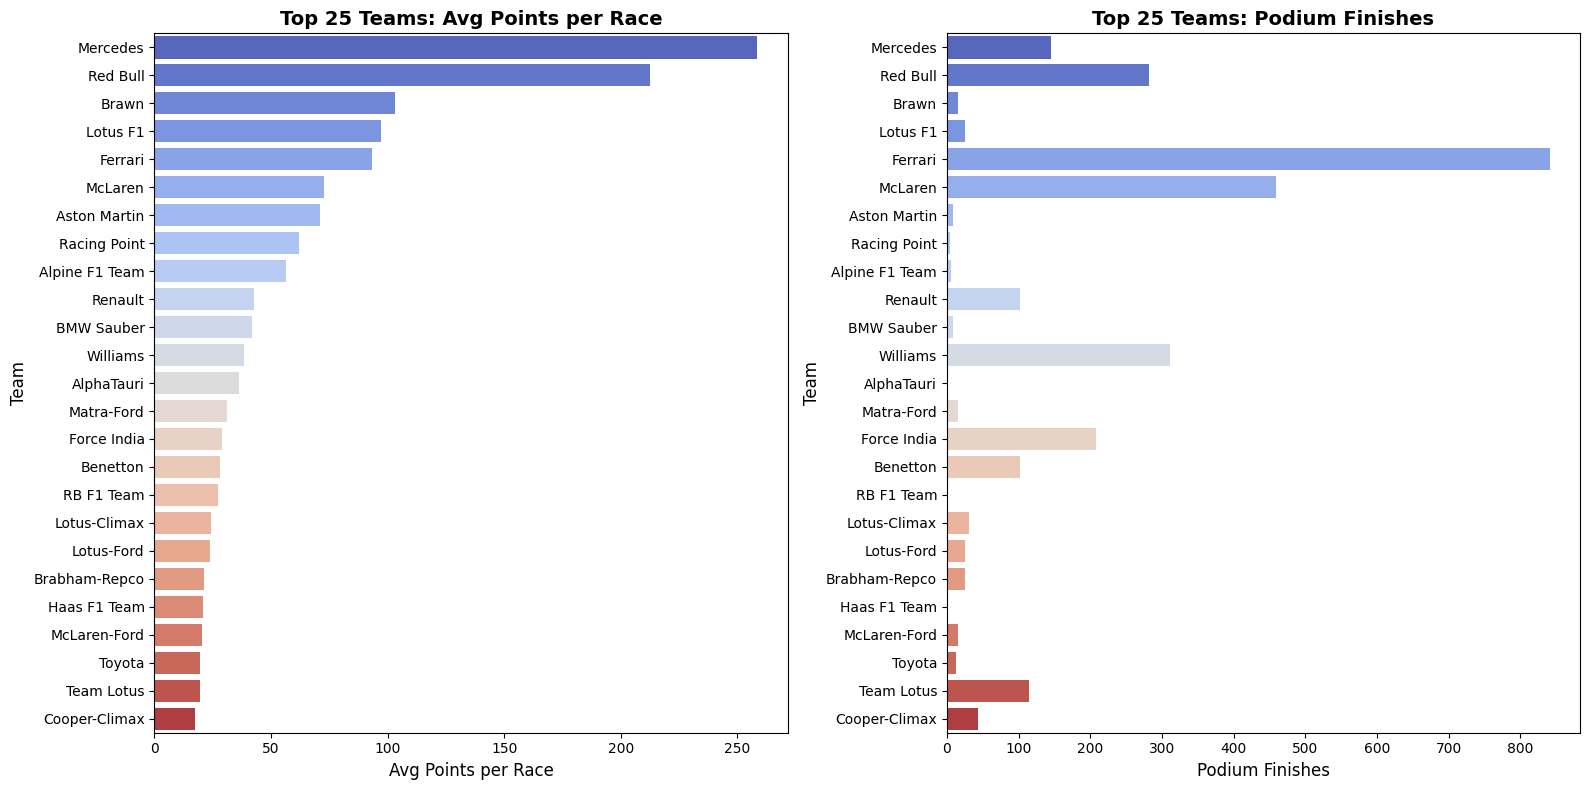

In [16]:
def compare_team_performance():
    # Compute total races per team
    total_races = results.groupby('constructorId')['raceId'].nunique().reset_index()
    total_races.rename(columns={'raceId': 'total_races'}, inplace=True)

    # Compute total points per team
    team_points = constructor_standings.groupby('constructorId')['points'].sum().reset_index()
    # Merge race counts and points
    team_performance = team_points.merge(total_races, on='constructorId')
    team_performance['avg_points_per_race'] = team_performance['points'] / team_performance['total_races']
    # Compute podium finishes
    podium_finishes = results[results['positionOrder'] <= 3].groupby('constructorId')['raceId'].count().reset_index()
    podium_finishes.rename(columns={'raceId': 'podium_finishes'}, inplace=True)
    # Merge all performance metrics
    team_performance = team_performance.merge(podium_finishes, on='constructorId', how='left').fillna(0)
    team_performance = team_performance.merge(constructors[['constructorId', 'name']], on='constructorId')
    team_performance = team_performance.sort_values('avg_points_per_race', ascending=False)
    # Select only the top 25 teams
    top_teams = team_performance.head(25)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot Avg Points per Race
    sns.barplot(ax=axes[0], x='avg_points_per_race', y='name', data=top_teams, palette='coolwarm')
    axes[0].set_title("Top 25 Teams: Avg Points per Race", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Avg Points per Race", fontsize=12)
    axes[0].set_ylabel("Team", fontsize=12)
    axes[0].tick_params(axis='y', labelsize=10)  # Improve readability

    # Plot Podium Finishes
    sns.barplot(ax=axes[1], x='podium_finishes', y='name', data=top_teams, palette='coolwarm')
    axes[1].set_title("Top 25 Teams: Podium Finishes", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Podium Finishes", fontsize=12)
    axes[1].set_ylabel("Team", fontsize=12)
    axes[1].tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

compare_team_performance()

##8.	Driver Consistency in Race Performance

####	Identify drivers with consistent top finishes and those with fluctuating results.

<ipython-input-17-177bb8feac02>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='positionOrder', y='surname', data=consistent_drivers, palette='viridis')


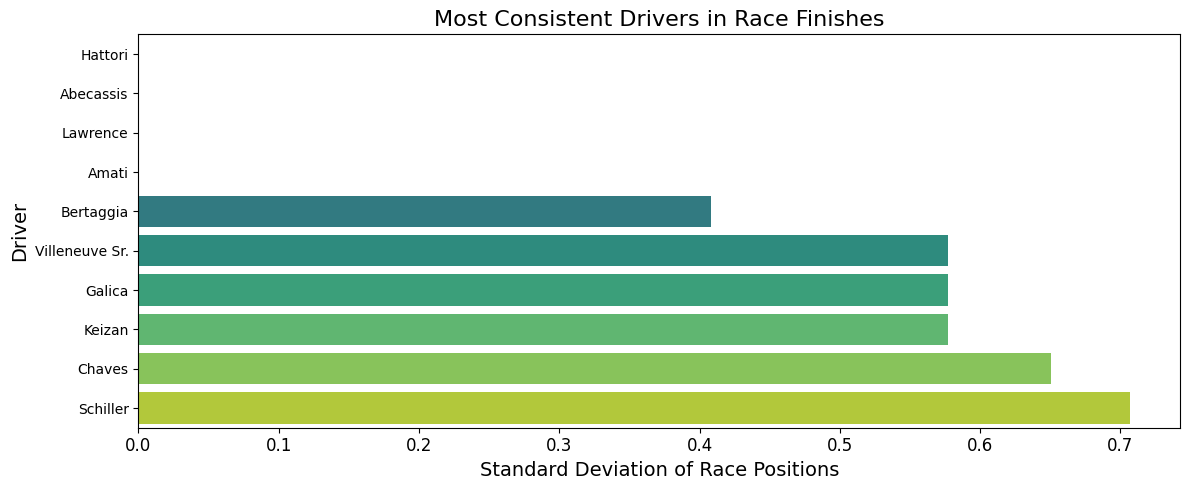

In [17]:
# Driver Consistency in Race Performance
def driver_consistency():
    results['positionOrder'] = pd.to_numeric(results['positionOrder'], errors='coerce')
    driver_positions = results.groupby('driverId')['positionOrder'].std().reset_index()
    driver_positions.dropna(subset=['positionOrder'], inplace=True)
    driver_positions = driver_positions.merge(drivers[['driverId', 'surname']], on='driverId', how='left')
    driver_positions.fillna("Unknown", inplace=True)
    driver_positions = driver_positions.sort_values('positionOrder', ascending=True)
    consistent_drivers = driver_positions.head(10)
    plt.figure(figsize=(12, len(consistent_drivers) * 0.5))
    sns.barplot(x='positionOrder', y='surname', data=consistent_drivers, palette='viridis')
    plt.xlabel("Standard Deviation of Race Positions", fontsize=14)
    plt.ylabel("Driver", fontsize=14)
    plt.title("Most Consistent Drivers in Race Finishes", fontsize=16)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.show()
driver_consistency()



##9.	Lap Time Efficiency:
####	Compare lap times across different circuits and identify which teams maximize efficiency.

<ipython-input-18-3dcce32fd211>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='milliseconds', y='surname', data=avg_lap_times.head(10), palette='Blues_r')


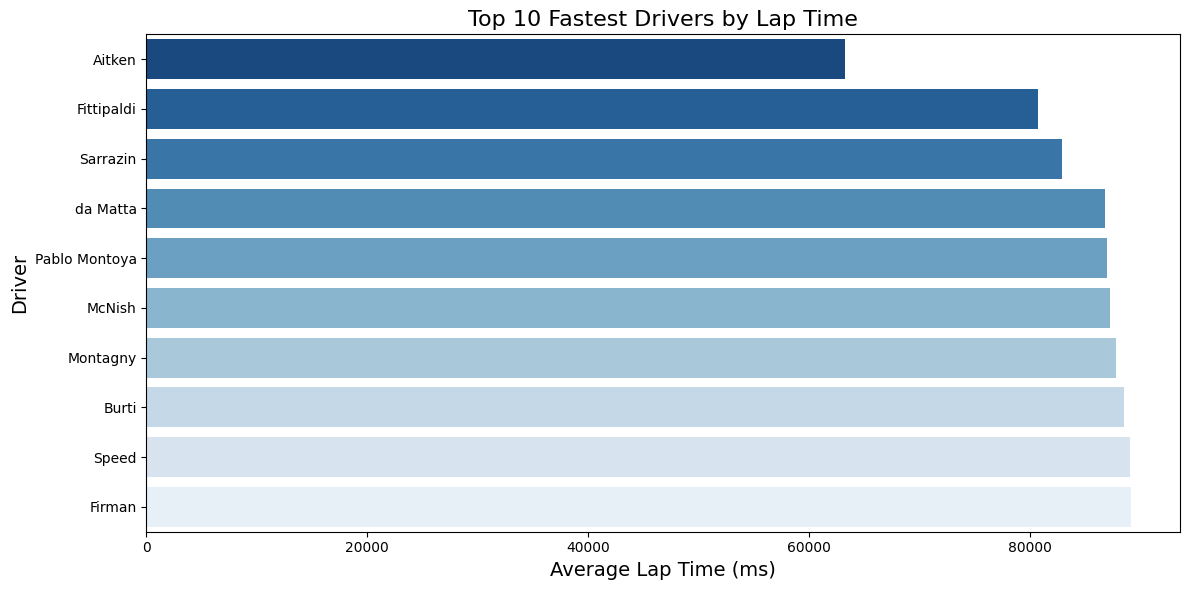

In [18]:
# Lap Time Efficiency
def lap_time_efficiency():
    avg_lap_times = lap_times.groupby('driverId')['milliseconds'].mean().reset_index()
    avg_lap_times = avg_lap_times.merge(drivers[['driverId', 'surname']], on='driverId')
    avg_lap_times = avg_lap_times.sort_values('milliseconds')
    plt.figure(figsize=(12, 6))
    sns.barplot(x='milliseconds', y='surname', data=avg_lap_times.head(10), palette='Blues_r')
    plt.xlabel("Average Lap Time (ms)", fontsize=14)
    plt.ylabel("Driver", fontsize=14)
    plt.title("Top 10 Fastest Drivers by Lap Time", fontsize=16)
    plt.tight_layout()
    plt.show()
lap_time_efficiency()



##10.	Best Team Lineup:
####	Build the best possible team lineup based on driver performance trends.

<ipython-input-19-050c6241a660>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points', y='name', data=top_teams, palette='coolwarm')


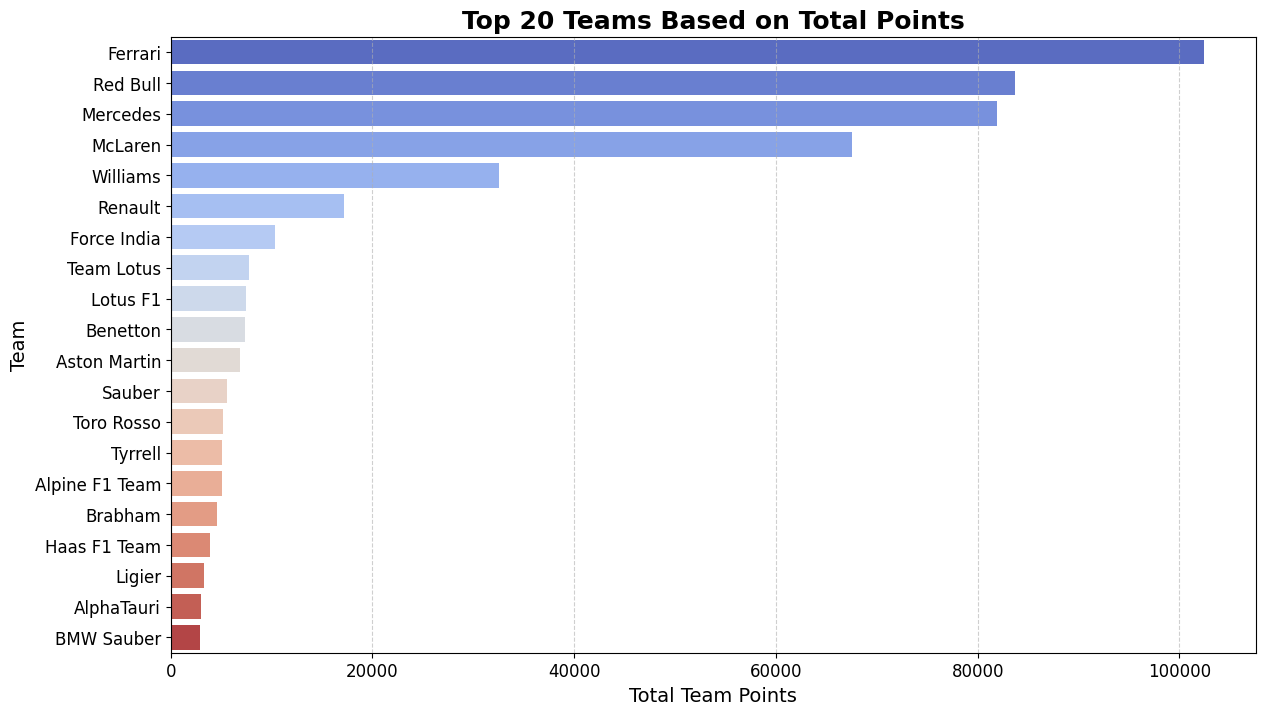

In [19]:
def best_team_lineup():

    # Load datasets
    #constructors = pd.read_csv('C:\\Users\\harin\\OneDrive\\Desktop\\hackathon-data premier\\constructors.csv')
    #constructor_standings = pd.read_csv('C:\\Users\\harin\\OneDrive\\Desktop\\hackathon-data premier\\constructor_standings.csv')

    # Aggregate total points per team
    team_points = constructor_standings.groupby('constructorId')['points'].sum().reset_index()
    # Merge with team names
    team_points = team_points.merge(constructors[['constructorId', 'name']], on='constructorId')

    # Sort by points and take top 20 teams for better visualization
    top_teams = team_points.sort_values('points', ascending=False).head(20)

    # Plot with better styling
    plt.figure(figsize=(14, 8))
    sns.barplot(x='points', y='name', data=top_teams, palette='coolwarm')
    # Beautify the plot
    plt.title("Top 20 Teams Based on Total Points", fontsize=18, fontweight='bold')
    plt.xlabel("Total Team Points", fontsize=14)
    plt.ylabel("Team", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Show plot
    plt.show()
best_team_lineup()



#11. Predictions for 2025 Season:
###### Who will win the Drivers' and Constructors' Championship based on historical and current data?


Mean Absolute Error: 530.20

Predicted Top Drivers for 2025:
     forename     surname  predicted_points
821       Max  Verstappen       5754.678223
837     Lando      Norris       3763.438965
782      Nico     Rosberg       3724.908691
835   Charles     Leclerc       3152.792969
848     Oscar     Piastri       3090.784912
788     Lewis    Hamilton       2523.946289
806    Sergio       Pérez       2230.841064
823    Carlos       Sainz       2224.013184
838    George     Russell       2201.338623
755  Fernando      Alonso       1104.706177


<ipython-input-20-9c53ea996bff>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drivers, x="predicted_points", y="surname", palette="Blues_r")


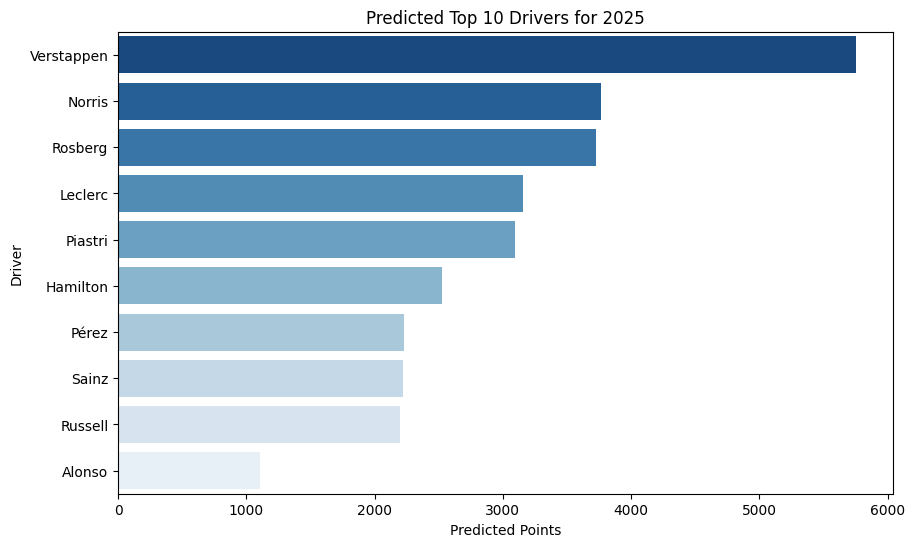

In [20]:
# Merge driver standings with race year
driver_trends = driver_standings.merge(races[['raceId', 'year']], on='raceId')

# Aggregate driver performance by year
driver_performance = driver_trends.groupby(['year', 'driverId']).agg(
    total_points=('points', 'sum'),
    avg_position=('position', 'mean'),
    wins=('wins', 'sum')
).reset_index()

# Get most recent data for training (last 10 years)
recent_data = driver_performance[driver_performance['year'] >= 2015]

# Prepare features and target variable
X = recent_data[['year', 'driverId']]
y = recent_data['total_points']

# One-hot encode driverId
X = pd.get_dummies(X, columns=['driverId'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

# Predict for 2025 season
future_year = 2025
future_drivers = driver_performance['driverId'].unique()
X_future = pd.DataFrame({'year': [future_year] * len(future_drivers), 'driverId': future_drivers})
X_future = pd.get_dummies(X_future, columns=['driverId'])

# 🔹 Ensure `X_future` has the same columns as `X_train`
missing_cols = set(X_train.columns) - set(X_future.columns)
for col in missing_cols:
    X_future[col] = 0  # Add missing columns with zero values

# 🔹 Ensure column order matches `X_train`
X_future = X_future[X_train.columns]

# Make predictions
future_predictions = model.predict(X_future)
predictions_df = pd.DataFrame({'driverId': future_drivers, 'predicted_points': future_predictions})
predictions_df = predictions_df.merge(drivers[['driverId', 'forename', 'surname']], on='driverId')

# Sort and display top predicted drivers
top_drivers = predictions_df.sort_values(by='predicted_points', ascending=False).head(10)
print("\nPredicted Top Drivers for 2025:")
print(top_drivers[['forename', 'surname', 'predicted_points']])

# Visualize Predictions
plt.figure(figsize=(10, 6))
sns.barplot(data=top_drivers, x="predicted_points", y="surname", palette="Blues_r")
plt.xlabel("Predicted Points")
plt.ylabel("Driver")
plt.title("Predicted Top 10 Drivers for 2025")
plt.show()


#12. Struggling Teams Analysis:
######    Predict which team is most likely to underperform in the upcoming 2025 season based on historical trends.

<ipython-input-21-b2c3d6677a58>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=predictions_df, x='Predicted_Position', y='Team', palette='Reds_r')


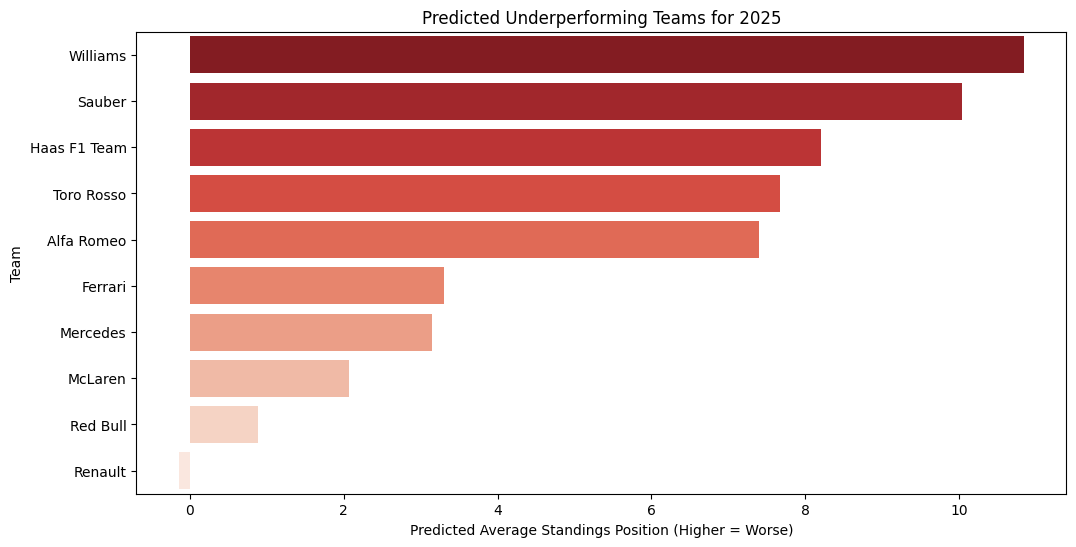


**Predicted Underperforming Teams in 2025:**
           Team  Predicted_Position
6      Williams           10.844833
4        Sauber           10.043291
7  Haas F1 Team            8.206614
5    Toro Rosso            7.667268
9    Alfa Romeo            7.403972
0       Ferrari            3.299360
2      Mercedes            3.149091
1       McLaren            2.063104
3      Red Bull            0.888389
8       Renault           -0.144888


In [21]:
def struggling_team_analysis():
  # Merge datasets to get season-year mapping
  standings = constructor_standings.merge(races[['raceId', 'year']], on='raceId') \
                                  .merge(constructors[['constructorId', 'name']], on='constructorId')

  # Aggregate by season
  team_trends = standings.groupby(['year', 'name']).agg(
      avg_position=('position', 'mean'),
      total_points=('points', 'sum')
  ).reset_index()

  # Identify the top struggling teams based on recent performance drop
  recent_trend = team_trends[team_trends['year'] >= 2015]

  # Perform regression to predict 2025 performance
  predictions = []
  for team in recent_trend['name'].unique():
      team_data = recent_trend[recent_trend['name'] == team].sort_values(by='year')

      if len(team_data) < 5:  # Ensure sufficient data points for prediction
          continue

      X = team_data[['year']].values
      y = team_data['avg_position'].values  # Higher position means worse performance

      model = LinearRegression()
      model.fit(X, y)

      pred_2025 = model.predict(np.array([[2025]]))[0]
      predictions.append((team, pred_2025))

  # Convert predictions to DataFrame and sort
  predictions_df = pd.DataFrame(predictions, columns=['Team', 'Predicted_Position'])
  predictions_df = predictions_df.sort_values(by='Predicted_Position', ascending=False)  # Worst teams first

  # Plot the trend
  plt.figure(figsize=(12, 6))
  sns.barplot(data=predictions_df, x='Predicted_Position', y='Team', palette='Reds_r')
  plt.xlabel("Predicted Average Standings Position (Higher = Worse)")
  plt.ylabel("Team")
  plt.title("Predicted Underperforming Teams for 2025")
  plt.show()

  print("\n**Predicted Underperforming Teams in 2025:**")
  print(predictions_df)

struggling_team_analysis()

# 13. Driver-Specific Track Struggles:
###### Identify circuits where specific drivers consistently struggle or excel.


<ipython-input-22-298697d1780a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance, x='avg_position', y='name', palette='coolwarm')


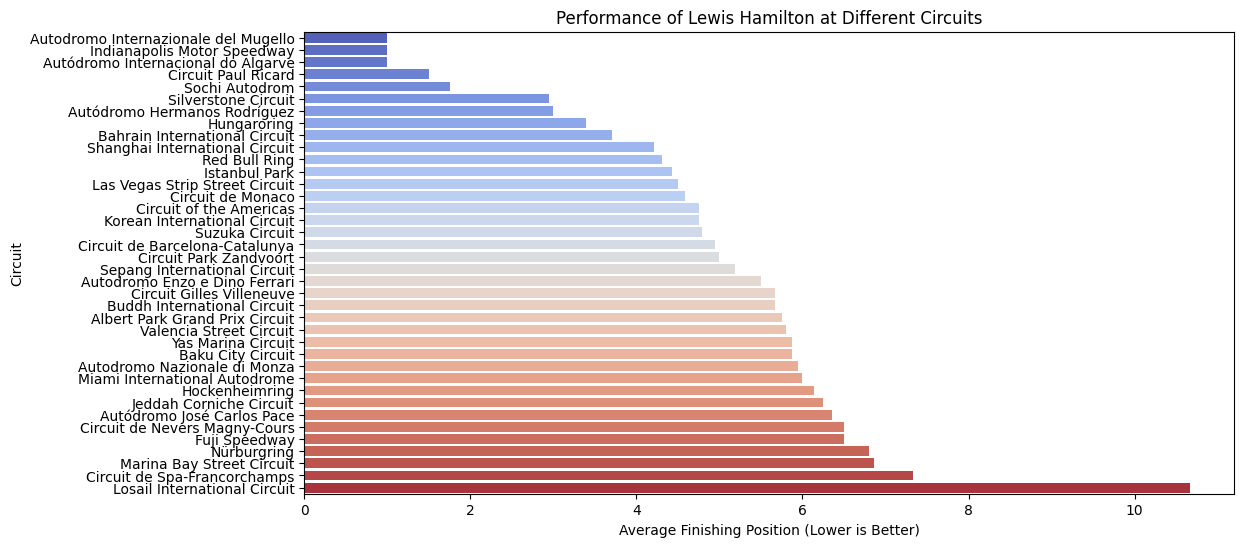


**Performance Metrics:**
                                    name  avg_position    win_rate  \
2   Autodromo Internazionale del Mugello      1.000000  100.000000   
21           Indianapolis Motor Speedway      1.000000  100.000000   
5     Autódromo Internacional do Algarve      1.000000  100.000000   
12                   Circuit Paul Ricard      1.500000   50.000000   
34                        Sochi Autodrom      1.750000   62.500000   
33                   Silverstone Circuit      2.947368   47.368421   
4           Autódromo Hermanos Rodríguez      3.000000   22.222222   
20                           Hungaroring      3.388889   44.444444   
7          Bahrain International Circuit      3.705882   29.411765   
32        Shanghai International Circuit      4.214286   42.857143   
30                         Red Bull Ring      4.307692   15.384615   
22                         Istanbul Park      4.428571   28.571429   
25        Las Vegas Strip Street Circuit      4.500000    0.0000

In [22]:
def driver_circuit_performance(driver_name):
    # Merge results with race and circuit data
    merged = results.merge(races[['raceId', 'circuitId', 'year']], on='raceId') \
                    .merge(circuits[['circuitId', 'name']], on='circuitId') \
                    .merge(drivers[['driverId', 'forename', 'surname']], on='driverId')

    # Filter for the selected driver
    merged['driver_fullname'] = merged['forename'] + " " + merged['surname']
    driver_data = merged[merged['driver_fullname'] == driver_name]

    # Calculate performance metrics
    performance = driver_data.groupby('name').agg(
        avg_position=('positionOrder', 'mean'),  # Lower is better
        win_rate=('positionOrder', lambda x: (x == 1).sum() / len(x) * 100),
        avg_points=('points', 'mean'),
        dnf_rate=('statusId', lambda x: (x > 1).sum() / len(x) * 100)  # Assumes statusId > 1 means DNF
    ).reset_index()

    # Sort by average finishing position
    performance = performance.sort_values(by='avg_position', ascending=True)

    # Plot performance at different circuits
    plt.figure(figsize=(12, 6))
    sns.barplot(data=performance, x='avg_position', y='name', palette='coolwarm')
    plt.xlabel('Average Finishing Position (Lower is Better)')
    plt.ylabel('Circuit')
    plt.title(f'Performance of {driver_name} at Different Circuits')
    plt.show()

    print("\n**Performance Metrics:**")
    print(performance)

# Example: Analyze Lewis Hamilton's track struggles
driver_circuit_performance("Lewis Hamilton")


#14. Championship Retention Probability:
###### What is the probability that this season’s winner will retain the title in the next season? Analyze historical trends of back-to-back champions.

In [23]:
def championship_retention_probability():
    # Extract the champion (driver with the highest points) for each season
    season_champions = driver_standings.sort_values(['raceId', 'points'], ascending=[True, False]) \
                                       .groupby('raceId').first().reset_index()

    # Merge with race data to get the year
    season_champions = season_champions.merge(races[['raceId', 'year']], on='raceId', how='left')

    # Keep only relevant columns (driverId, year)
    season_champions = season_champions[['year', 'driverId']].rename(columns={'driverId': 'championId'})

    # Shift the column to check retention
    season_champions['next_season_champion'] = season_champions['championId'].shift(-1)
    season_champions['retained_title'] = season_champions['championId'] == season_champions['next_season_champion']

    # Calculate retention probability
    total_seasons = season_champions.shape[0] - 1  # Exclude the last season (no next champion)
    retained_count = season_champions['retained_title'].sum()

    retention_probability = retained_count / total_seasons if total_seasons > 0 else 0

    print(f"🔹 Historical Championship Retention Probability: {retention_probability:.2%}")

    # Display past champions with retention status
    print("\nChampionship Retention History:")
    print(season_champions[['year', 'championId', 'retained_title']])

# Call the function
championship_retention_probability()

🔹 Historical Championship Retention Probability: 78.65%

Championship Retention History:
      year  championId  retained_title
0     2009          18            True
1     2009          18            True
2     2009          18            True
3     2009          18            True
4     2009          18            True
...    ...         ...             ...
1120  2024         830            True
1121  2024         830            True
1122  2024         830            True
1123  2024         830            True
1124  2024         830           False

[1125 rows x 3 columns]


# 15. Champion Age Trends:
###### Identify the age ranges where drivers consistently win championships across different decades.

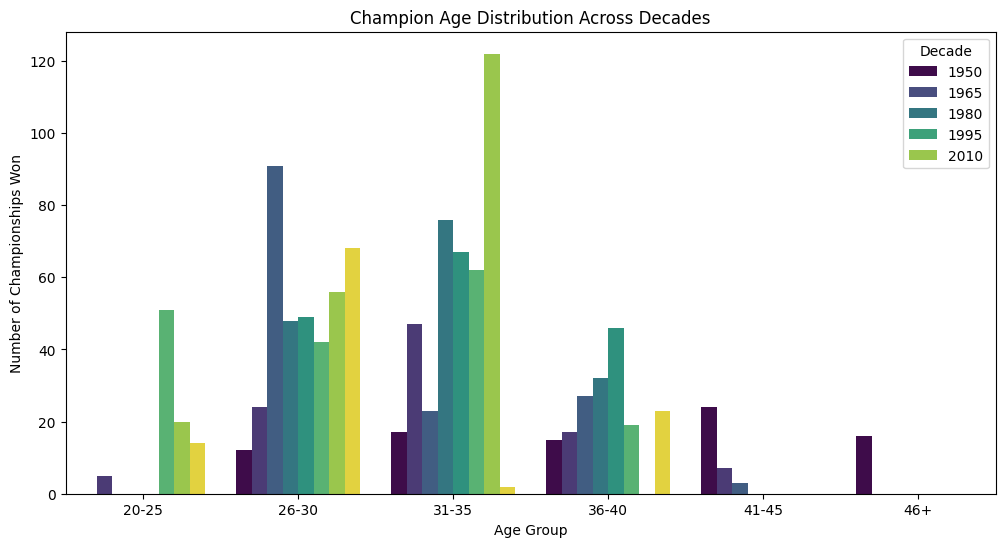


Champion Age Distribution Over Decades:
age_group  20-25  26-30  31-35  36-40  41-45  46+
decade                                           
1950           0     12     17     15     24   16
1960           5     24     47     17      7    0
1970           0     91     23     27      3    0
1980           0     48     76     32      0    0
1990           0     49     67     46      0    0
2000          51     42     62     19      0    0
2010          20     56    122      0      0    0
2020          14     68      2     23      0    0


<ipython-input-24-1d7af936f8cf>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(season_champions.groupby(['decade', 'age_group'])['driverId'].count().unstack())


In [24]:
def champion_age_trends():
    # Extract the champion (driver with the highest points) for each season
    season_champions = driver_standings.sort_values(['raceId', 'points'], ascending=[True, False]) \
                                       .groupby('raceId').first().reset_index()

    # Merge with races to get the season year
    season_champions = season_champions.merge(races[['raceId', 'year']], on='raceId', how='left')

    # Merge with drivers to get birthdates
    season_champions = season_champions.merge(drivers[['driverId', 'dob']], on='driverId', how='left')

    # Convert birth date to datetime format
    season_champions['dob'] = pd.to_datetime(season_champions['dob'])

    # Calculate age at the time of winning the championship
    season_champions['champion_age'] = season_champions['year'] - season_champions['dob'].dt.year

    # Define age ranges
    bins = [20, 25, 30, 35, 40, 45, 50]
    labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46+']
    season_champions['age_group'] = pd.cut(season_champions['champion_age'], bins=bins, labels=labels, right=False)

    # Extract the decade
    season_champions['decade'] = (season_champions['year'] // 10) * 10

    # Plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=season_champions, x='age_group', hue='decade', palette="viridis")
    plt.title("Champion Age Distribution Across Decades")
    plt.xlabel("Age Group")
    plt.ylabel("Number of Championships Won")
    plt.legend(title="Decade")
    plt.show()

    # Print results
    print("\nChampion Age Distribution Over Decades:")
    print(season_champions.groupby(['decade', 'age_group'])['driverId'].count().unstack())

# Call the function
champion_age_trends()

KeyError: 'year'